In [50]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal
from sklearn.decomposition import FastICA, PCA

## Synthetic Signal mixing and the coresponding Spike trains

In [51]:
# Parameters
t_duration = 500  # duration in seconds
dt = 0.1  # time step (in seconds)
t = np.arange(0, t_duration, dt)

In [52]:
#Composing the signal and the mixing them

np.random.seed(0)
n_samples = 5000 #2000
time = np.linspace(0, 10, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.cos(15 * time)  # Signal 1 : sinusoidal signal
s3 = np.sin(1 * time)*np.cos(50 * time)  # Signal 1 : sinusoidal signal

# s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
# s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
# s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal


S = np.c_[s1, s2, s3]
#S += 0.2 * np.random.normal(size=S.shape)  # Adding noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix, linear mix

#A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # Identity Mixing matrix for testing

X = np.dot(S, A.T)  # Generate observations



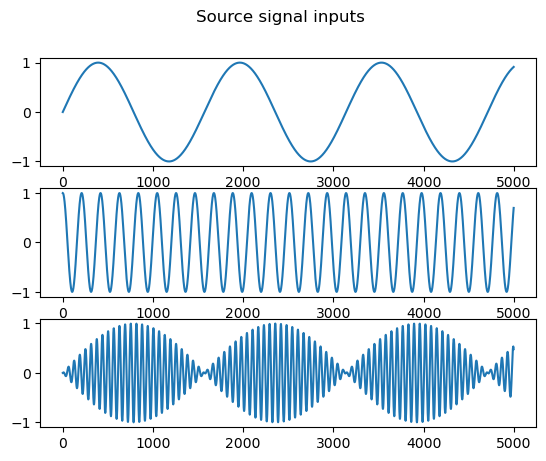

In [9]:
fig1, axs1 = plt.subplots(nrows=3, ncols=1)#, figsize=(12, 4))
axs1[0].plot(s1)
axs1[1].plot(s2)
axs1[2].plot(s3)
fig1.suptitle('Source signal inputs')
plt.show()

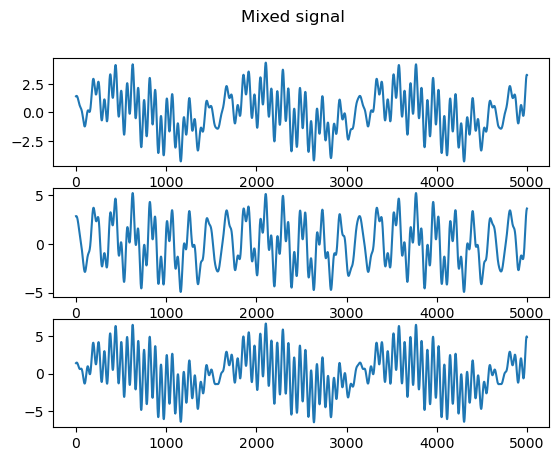

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=1)#, figsize=(12, 4))
axs[0].plot(X[:,0])
axs[1].plot(X[:,1])
axs[2].plot(X[:,2])
fig.suptitle('Mixed signal')
plt.show()

In [54]:
#Spike generation, from the source signals

#Treat the discretised Non stationary poisson process as a form of Bernoulli process 

f_sin = 5  # frequency of the sinusoidal latent dynamics
baseline_firing_rate = 50  # baseline firing rate
modulation_depth = 10  # modulation depth of firing rate (Hz)


mixed_dynamics = X

Spiked_sig1 = baseline_firing_rate + modulation_depth * mixed_dynamics[:,0]
Spiked_sig2 = baseline_firing_rate + modulation_depth * mixed_dynamics[:,1]
Spiked_sig3 = baseline_firing_rate + modulation_depth * mixed_dynamics[:,2]

#   ---   ---   ---   
#Normalizing the Dynamics to be btw 0,1 

Spiked_sig1 = Spiked_sig1 / np.max(Spiked_sig1)
Spiked_sig2 = Spiked_sig2 / np.max(Spiked_sig2)
Spiked_sig3 = Spiked_sig3 / np.max(Spiked_sig3)

gaus_vector = np.random.normal(0.5,0.1,len(t))
# Truncate values to be between 0 and 1
gaus_vector = np.clip(gaus_vector, 0, 1)

# Generate spike train using gaussian random values to compare values
spike_train1 = gaus_vector < Spiked_sig1 
spike_times1 = t1[spike_train1]

spike_train2 = gaus_vector < Spiked_sig2 
spike_times2 = t2[spike_train2]

spike_train3 = gaus_vector < Spiked_sig3
spike_times3 = t3[spike_train3]

In [13]:
#spike generation -> as suggested in the calfads papers  

#mixed_sig = X.copy()

#mixed_sig = (mixed_sig - np.min(mixed_sig))*(2)/(np.max(mixed_sig) - np.min(mixed_sig))-1
#normalized to be btw -1 and 1


# Num_Neurons = 30

# W = np.random.normal(0, (1/np.sqrt(Num_Neurons))*np.eye(len(s1)))#, (n_rows, n_columns))

# lambda_matrix = np.exp(np.matmul(W, mixed_sig) + 0.5)

# spikecount = np.random.poisson(lambda_matrix*0.1)

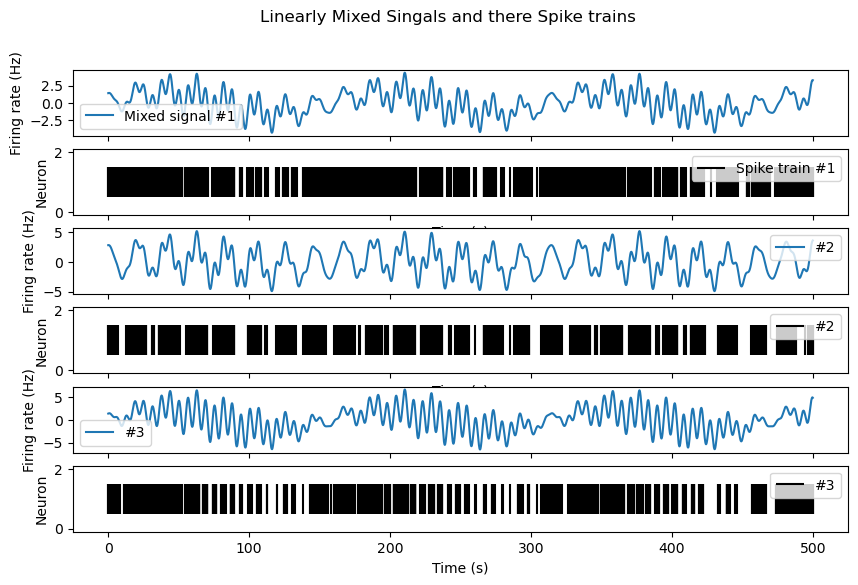

In [55]:
# Plot
fig3, ax = plt.subplots(6, 1, figsize=(10, 6), sharex=True)
ax[0].plot(t1, mixed_dynamics[:,0], label="Mixed signal #1")
ax[0].set_ylabel("Firing rate (Hz)")
ax[0].legend()

ax[1].eventplot(spike_times1, color='black', label="Spike train #1")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Neuron")
ax[1].legend()

ax[2].plot(t2, mixed_dynamics[:,1],label= "#2")
ax[2].set_ylabel("Firing rate (Hz)")
ax[2].legend()

ax[3].eventplot(spike_times2, color='black',label= "#2")
ax[3].set_xlabel("Time (s)")
ax[3].set_ylabel("Neuron")
ax[3].legend()

ax[4].plot(t2, mixed_dynamics[:,2],label= "#3")
ax[4].set_ylabel("Firing rate (Hz)")
ax[4].legend()

ax[5].eventplot(spike_times3, color='black',label= "#3")
ax[5].set_xlabel("Time (s)")
ax[5].set_ylabel("Neuron")
ax[5].legend()


fig3.suptitle('Linearly Mixed Singals and there Spike trains')


plt.show()

### ICA - on reconstructing the signal from Spike train

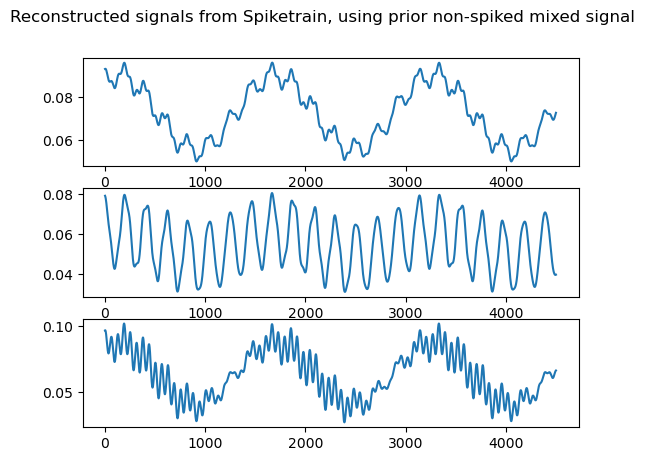

In [59]:
#Inversely generate the Dynamics from the Spike Data and then perform ICA


# Parameters for reconstruction
window_duration = 450  # duration of the averaging window (in seconds) 450 works the best dont know why
window_size = int(window_duration / dt)

# Initialize the reconstructed sinusoidal latent dynamics
reconstructed1 = np.zeros(window_size)
reconstructed2 = np.zeros(window_size)
reconstructed3 = np.zeros(window_size)


# Loop over spike times and accumulate the sinusoidal latent dynamics
for spike_time in spike_times1:
    spike_index = int(spike_time / dt)
    if spike_index < len(t) - window_size:
        reconstructed1 += Spiked_sig1[spike_index:spike_index + window_size]
#Here we use the orignal signal generation function to reconstruct the signal from Spiketime information
#but since there is noise/randomness in spiketime data the reconstruction is not exact

# Big Problem!  - since ideally the reconstruction should not assume any prior function 
#This is done below using a gaussian convolution
   

for spike_time in spike_times2:
    spike_index = int(spike_time / dt)
    if spike_index < len(t) - window_size:
        reconstructed2 += Spiked_sig2[spike_index:spike_index + window_size]
        


for spike_time in spike_times3:
    spike_index = int(spike_time / dt)
    if spike_index < len(t) - window_size:
        reconstructed3 += Spiked_sig3[spike_index:spike_index + window_size]
        

        
# Normalize the reconstructed signal with the total number of spikes
reconstructed1 /= len(spike_times1)
reconstructed2 /= len(spike_times2)
reconstructed3 /= len(spike_times3)


fig1, axs1 = plt.subplots(nrows=3, ncols=1)#, figsize=(12, 4))
axs1[0].plot(reconstructed1)
axs1[1].plot(reconstructed2)
axs1[2].plot(reconstructed3)
fig1.suptitle('Reconstructed signals from Spiketrain, using prior non-spiked mixed signal')
plt.show()

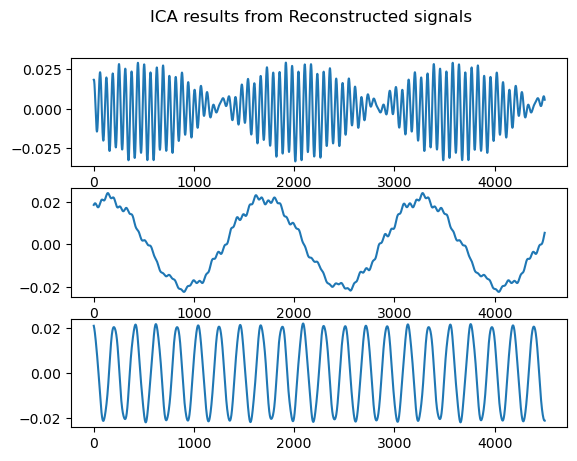

In [60]:
# Compute ICA

X_mix = np.c_[reconstructed1, reconstructed2, reconstructed3]

ica = FastICA(n_components=3, whiten="arbitrary-variance")
S_ = ica.fit_transform(X_mix)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

#---plots---

fig1, axs1 = plt.subplots(nrows=3, ncols=1)#, figsize=(12, 4))
axs1[0].plot(S_[:,0])
axs1[1].plot(S_[:,1])
axs1[2].plot(S_[:,2])
fig1.suptitle('ICA results from Reconstructed signals')
plt.show()   #Decent results - considering loss of information in constructing the poisson process 

 ### Attempt at reconstructing Dynamics with only the spiketime data 
 
Assuming no prior information about the fucntion used to generate the signal, using gassian processes

And then performing ICA to decomposed the reconstructed mixed signals

In [61]:
#Spike time vector are uneven in the there dimentions, which can be fixed by generating new spiketrains 
spike_times1.shape, spike_times2.shape, spike_times3.shape

((2874,), (2460,), (1959,))

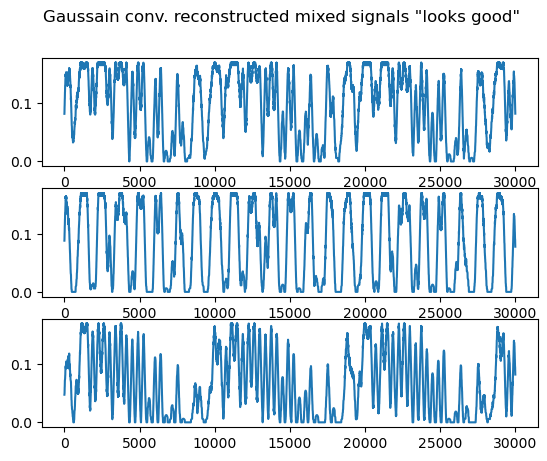

In [49]:
#Performing Gaussian kernel convolution on the spike train to get a smooth signal since ICA on spiketrains seems to be problomatic


sp1 = spike_times1.copy()
sp2 = spike_times2.copy()
sp3 = spike_times3.copy()


def generate_spike_train(spike_times, duration):

    spike_train = np.zeros(duration)
    spike_train[spike_times] = 1
    return spike_train

duration = 5000

dt_vec = np.dot(np.ones(len(spike_times1)),dt)

volume = 6 #scales the spike times and increasing the distance between the spikes for a better gaussian convolution

hold_vec1 = np.dot(sp1*volume,1/dt).astype(int)
hold_vec2 = np.dot(sp2*volume,1/dt).astype(int)
hold_vec3 = np.dot(sp3*volume,1/dt).astype(int)


re_spike_train1 = generate_spike_train(hold_vec1, volume*duration)
re_spike_train2 = generate_spike_train(hold_vec2, volume*duration)
re_spike_train3 = generate_spike_train(hold_vec3, volume*duration)



# Define the Gaussian kernel parameters
sigma = 100
L = 180

# Create the Gaussian kernel
n = np.arange(-(L // 2), (L // 2) + 1)
g = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-n**2 / (2 * sigma**2))

# Normalize the Gaussian kernel
g = g / np.sum(g)

# Perform convolution
smooth_sp1 = scipy.signal.convolve(re_spike_train1, g, mode='same')
smooth_sp2 = scipy.signal.convolve(re_spike_train2, g, mode='same')
smooth_sp3 = scipy.signal.convolve(re_spike_train3, g, mode='same')

fig113, axs113 = plt.subplots(nrows=3, ncols=1)#, figsize=(12, 4))
axs113[0].plot(smooth_sp1)
axs113[1].plot(smooth_sp2)
axs113[2].plot(smooth_sp3)
fig113.suptitle('Gaussain conv. reconstructed mixed signals "looks good"')
plt.show()

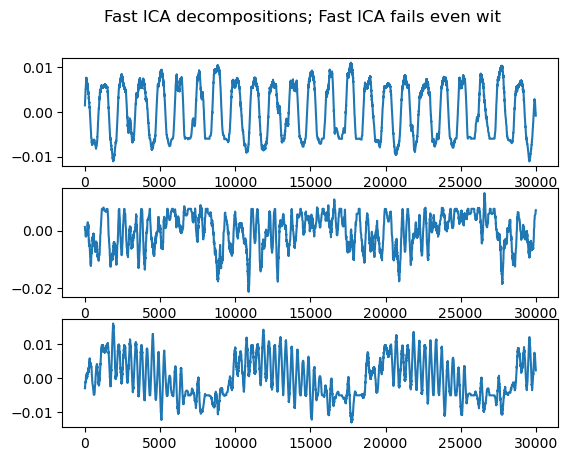

In [48]:
# Compute ICA on spike trains

X_mix_2 = np.c_[smooth_sp1, smooth_sp2, smooth_sp3]

ica_2 = FastICA(n_components=3, whiten="arbitrary-variance")
S_2_ = ica.fit_transform(X_mix_2)  # Reconstruct signals
A_2_ = ica.mixing_  # Get estimated mixing matrix

fig11, axs11 = plt.subplots(nrows=3, ncols=1)#, figsize=(12, 4))
axs11[0].plot(S_2_[:,0])
axs11[1].plot(S_2_[:,1])
axs11[2].plot(S_2_[:,2])
fig11.suptitle('Fast ICA decompositions; Fast ICA fails even wit')
plt.show()

Passing the Dynamics through the spike generation process somehow subdues a linear mixing likely